In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable **production éolienne** :

* SARIMAX avec des fonctions sinusoïdales correspondant aux saisons observées en régresseurs exogènes
* SARIMAX avec des données métier en régresseurs exogènes (vent, précipitation, etc).
* SARIMAX avec des données métier FILTREES en régresseurs exogènes
* SARIMAX sur le signal filtré par transformation de Fourier sans régresseur
* SARIMAX sur le signal filtré avec des données métier FILTREES en régresseurs exogènes
* Régression linéaire sur les données métiers FILTREES comme variables explicatives
* Régression linéaire sur la variable à expliquée FILTREE et avec les variables explicatives FILTREES.

**NOTA BENE :** Pour la période 3h, le calcul avec un modèle SARIMAX n'aboutit pas sans données exogènes en paramètre.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_3H.csv',
                usecols = ['Dates', 'Eolien'])
df.head(1)

,Dates,Eolien
0,2013-01-01 00:00:00,3975.8


In [3]:
df.shape

(25808, 2)

In [4]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [5]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

# Conversion en taux de charge pour annuler l'évolution dans le temps

In [6]:
capa = pd.read_csv('./datasource/capacite_eolien_FR.csv',
                  usecols = ['Dates', 'Capa_eol'])
capa['Dates'] = pd.to_datetime(capa['Dates'], format = '%Y/%m/%d %H:%M:%S', yearfirst = True)
capa.set_index('Dates', inplace = True)

In [7]:
capa.shape

(25808, 1)

In [8]:
df = pd.concat([df, capa], axis = 1)
df['TCH_eol'] = df['Eolien'] / df['Capa_eol']
df

,Eolien,Capa_eol,TCH_eol
Dates,,,
2013-01-01 00:00:00,3975.800000,7519,0.528767
2013-01-01 03:00:00,3538.166667,7519,0.470563
2013-01-01 06:00:00,3313.833333,7519,0.440728
2013-01-01 09:00:00,2749.833333,7519,0.365718
2013-01-01 12:00:00,2274.666667,7519,0.302522
...,...,...,...
2021-10-31 09:00:00,11114.833333,18570,0.598537
2021-10-31 12:00:00,12269.666667,18570,0.660725
2021-10-31 15:00:00,11351.000000,18570,0.611255


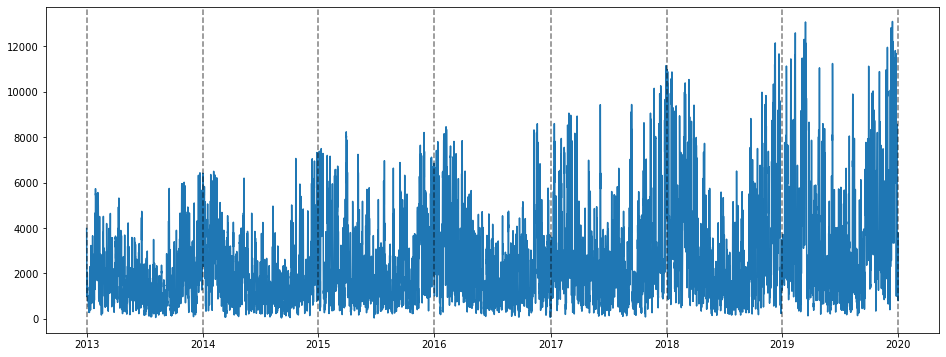

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(df['Eolien'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

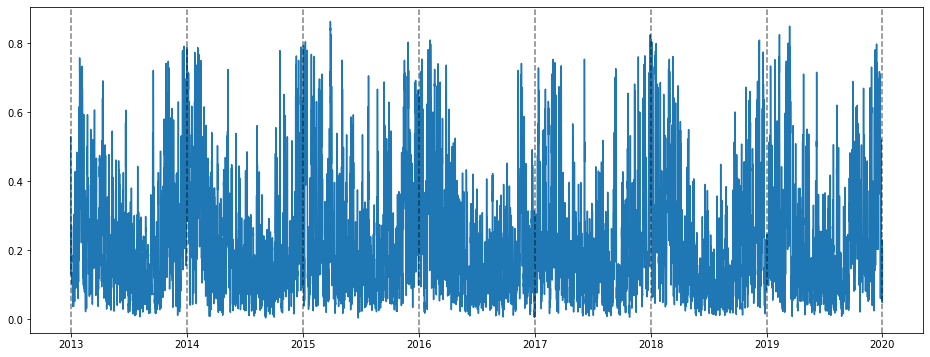

In [10]:
plt.figure(figsize=(16, 6))
plt.plot(df['TCH_eol'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

### Test de stationnarité

In [11]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df['TCH_eol'])

(-13.884944194996958,
 6.114282846592169e-26,
 49,
 25758,
 {'1%': -3.4306038998292085,
  '5%': -2.8616522161827964,
  '10%': -2.566829729367711},
 -95766.34015790067)

### Coéfficients SARIMAX et saisonnalités

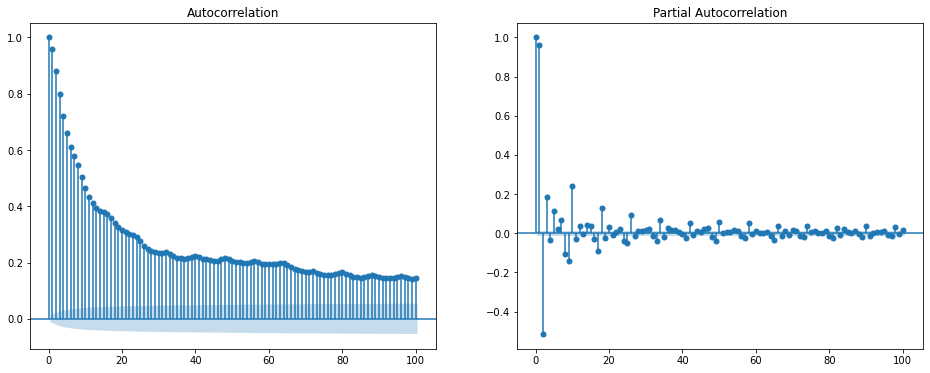

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df['TCH_eol'], lags = 100, ax=ax1)
plot_pacf(df['TCH_eol'], lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* jour

# Import du dataset filtré (Transformation de Fourier)

In [13]:
df_filtered = pd.read_csv('./dataset/France_3H_filtered.csv',
                usecols = ['Dates', 'Eolien'])
df_filtered.head(1)

,Dates,Eolien
0,2013-01-01 00:00:00,5085.207663


In [14]:
df_filtered['Dates'] = pd.to_datetime(df_filtered['Dates'], yearfirst = True)
df_filtered.set_index('Dates', inplace = True)

In [15]:
df_filtered = pd.concat([df_filtered, capa], axis = 1)
df_filtered['TCH_eol'] = df_filtered['Eolien'] / df_filtered['Capa_eol']

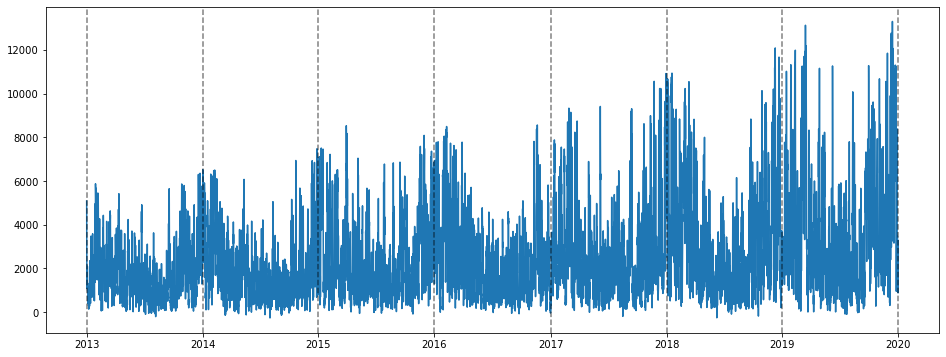

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered['Eolien'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

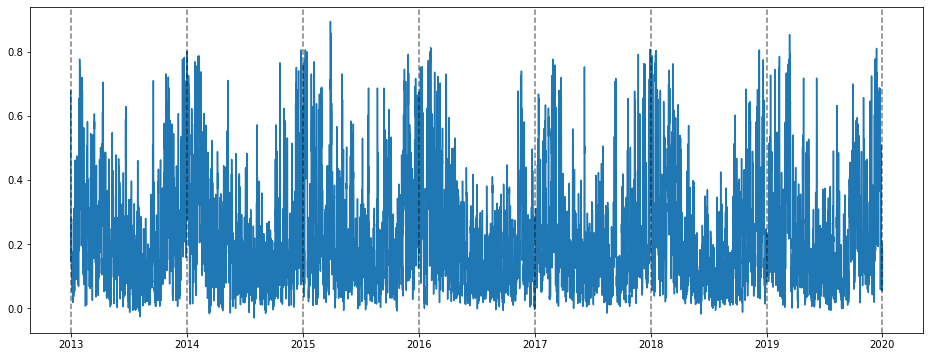

In [17]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered['TCH_eol'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

# Jeux d'entrainement et de test

In [18]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [19]:
df_train_filter = df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)]
df_test_filter = df_filtered[df_filtered.index >= fin]

In [20]:
fenetre = df_test.shape[0]

In [21]:
indice = df_test.index

In [22]:
bilan = df_test

# Paramètres SARIMAX

In [23]:
ordre = (3,0,0)
saison = (2,0,0,8)

# Régresseurs exogènes : sinus & cosinus suivant les saisonnalités

In [24]:
exog = pd.DataFrame({'date': df.index})
exog['date'] = pd.to_datetime(exog['date'])
# suivant saisonnalités
# exog['sin_D'] = np.sin(2 * np.pi * exog.index / 8)
# exog['cos_D'] = np.cos(2 * np.pi * exog.index / 8)
# exog['sin_W'] = np.sin(2 * np.pi * exog.index / 7)
# exog['cos_W'] = np.cos(2 * np.pi * exog.index / 7)
exog['sin_Y'] = np.sin(2 * np.pi * exog.index / 365.25)
exog['cos_Y'] = np.cos(2 * np.pi * exog.index / 365.25)
exog.set_index('date', inplace = True)

In [25]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

<ipython-input-26-56416ee0eedf>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])


''

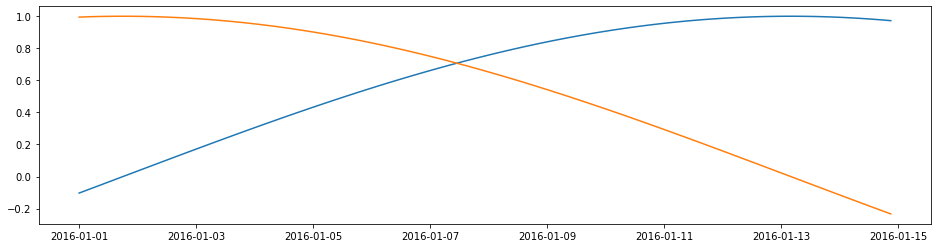

In [26]:
plt.figure(figsize=(16, 4))
plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])
# for year in range(debut.year, fin.year + 1): 
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### SARIMAX

In [27]:
model_sinus = sm.tsa.SARIMAX(df_train['TCH_eol'].values,
                             exog = exog_train.values,
                             order = ordre,
                             seasonal_order = saison)
result_sinus = model_sinus.fit()

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
predict_sinus = result_sinus.predict(start = 1 ,
                                     end = fenetre,
                                     exog = exog_test.values)

In [29]:
predict_sinus = pd.DataFrame(predict_sinus, columns=['Eol_p_sinus'], index = indice)

In [30]:
bilan = pd.concat([bilan, predict_sinus], axis = 1)

### Erreur absolue

In [31]:
bilan['Err_sinus'] = np.abs(bilan['Eol_p_sinus'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,4270.149689,17517.977612,0.245102,0.219094,0.167043
std,3155.214841,599.239016,0.182926,0.163859,0.149554
min,93.833333,16494.000000,0.005102,-0.035832,0.000047
25%,1772.583333,16999.000000,0.100891,0.096310,0.051459
50%,3351.333333,17507.000000,0.191223,0.175980,0.121957
75%,6128.958333,18036.000000,0.351667,0.299505,0.238786
max,14456.166667,18570.000000,0.810869,0.848968,0.794229


# Régresseurs exogènes : données métier

In [32]:
exog = pd.read_csv('./exog/exog_3H_FR.csv', sep = ';',
                   usecols = ['Dates', 'Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'])
exog.head(1)

,Dates,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression
0,2013-01-01 00:00:00,5.409751,86.301303,1.000891,8.130811,-1288.211642


In [33]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [34]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [35]:
model_exog = sm.tsa.SARIMAX(df_train['TCH_eol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [36]:
result_exog = model_exog.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                20448
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 8)   Log Likelihood               34998.019
Date:                           Wed, 04 May 2022   AIC                         -69974.038
Time:                                   10:30:44   BIC                         -69886.856
Sample:                                        0   HQIC                        -69945.545
                                         - 20448                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0759        nan        nan        nan         nan         nan
x2             0.0005   8.39e-05      6.121      0.000       0.000       0.001
x3            -0.0078      0.001    -10.783      0.000      -0.009      -0.006
x4            -0.0132      0.000    -68.262      0.000      -0.014      -0.013
x5         -5.727e-05        nan        nan        nan         nan         nan
ar.L1          0.8840        nan        nan        nan         nan         nan
ar.L2         -0.1569      0.008    -20.854      0.000      -0.172      -0.142
ar.L3         -0.0162      0.007     -2.334      0.020      -0.030      -0.003
ar.S.L8        0.4275      0.005     79.665      0.000       0.417       0.438
ar.S.L16       0.1302      0.007     19.715      0.000       0.117       0.143
sigma2         0.0017        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                 242.82   Jarque-Bera (JB):               460.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.23
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [38]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [39]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Eol_p_exog'])

In [40]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [41]:
bilan['Err_exog'] = np.abs(bilan['Eol_p_exog'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,4270.149689,17517.977612,0.245102,0.219094,0.167043,0.225329,0.162110
std,3155.214841,599.239016,0.182926,0.163859,0.149554,0.157409,0.143706
min,93.833333,16494.000000,0.005102,-0.035832,0.000047,-0.087166,0.000004
25%,1772.583333,16999.000000,0.100891,0.096310,0.051459,0.108250,0.053352
50%,3351.333333,17507.000000,0.191223,0.175980,0.121957,0.190612,0.119414
75%,6128.958333,18036.000000,0.351667,0.299505,0.238786,0.305642,0.232865
max,14456.166667,18570.000000,0.810869,0.848968,0.794229,0.887712,0.819360


# Régresseurs exogènes : données métier FILTREES

In [42]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'])
exog.head(1)

,Dates,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression
0,2013-01-01 00:00:00,5.269459,92.900351,0.602728,10.172597,-1286.569161


In [43]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [44]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [45]:
model_filter = sm.tsa.SARIMAX(df_train['TCH_eol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [46]:
result_filter = model_filter.fit(low_memory=True)

In [47]:
result_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                20448
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 8)   Log Likelihood               37576.910
Date:                           Wed, 04 May 2022   AIC                         -75131.820
Time:                                   10:31:44   BIC                         -75044.638
Sample:                                        0   HQIC                        -75103.328
                                         - 20448                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0950      0.002     51.390      0.000       0.091       0.099
x2             0.0044      0.000     25.716      0.000       0.004       0.005
x3             0.0275      0.003      8.898      0.000       0.021       0.034
x4            -0.0029      0.000     -6.653      0.000      -0.004      -0.002
x5             0.0003   1.65e-05     20.721      0.000       0.000       0.000
ar.L1          1.4430      0.008    187.567      0.000       1.428       1.458
ar.L2         -0.7722      0.012    -62.628      0.000      -0.796      -0.748
ar.L3          0.1635      0.008     20.835      0.000       0.148       0.179
ar.S.L8        0.1626      0.011     15.069      0.000       0.141       0.184
ar.S.L16       0.1502      0.011     14.184      0.000       0.129       0.171
sigma2         0.0017   2.35e-05     74.504      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                  35.67   Jarque-Bera (JB):              2457.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.46
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [48]:
predict_filter = result_filter.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [49]:
predict_filter = pd.DataFrame(predict_filter, index = indice, columns = ['Eol_p_filter'])

In [50]:
bilan = pd.concat([bilan, predict_filter], axis = 1)

### Erreur absolue

In [51]:
bilan['Err_exog_filter'] = np.abs(bilan['Eol_p_filter'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog,Eol_p_filter,Err_exog_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,4270.149689,17517.977612,0.245102,0.219094,0.167043,0.225329,0.162110,0.224965,0.163398
std,3155.214841,599.239016,0.182926,0.163859,0.149554,0.157409,0.143706,0.158937,0.146406
min,93.833333,16494.000000,0.005102,-0.035832,0.000047,-0.087166,0.000004,-0.039260,0.000056
25%,1772.583333,16999.000000,0.100891,0.096310,0.051459,0.108250,0.053352,0.104866,0.050005
50%,3351.333333,17507.000000,0.191223,0.175980,0.121957,0.190612,0.119414,0.185445,0.119178
75%,6128.958333,18036.000000,0.351667,0.299505,0.238786,0.305642,0.232865,0.302314,0.233809
max,14456.166667,18570.000000,0.810869,0.848968,0.794229,0.887712,0.819360,0.823272,0.780694


# Target FILTREE sans régresseur

### SARIMAX

In [52]:
model_reduit_noreg = sm.tsa.SARIMAX(df_train_filter['TCH_eol'].values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [53]:
result_reduit_noreg = model_reduit_noreg.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
result_reduit_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                20448
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 8)   Log Likelihood               51479.814
Date:                           Wed, 04 May 2022   AIC                        -102947.629
Time:                                   10:32:09   BIC                        -102900.075
Sample:                                        0   HQIC                       -102932.087
                                         - 20448                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3077      0.005    447.370      0.000       2.298       2.318
ar.L2         -2.0032      0.009   -211.998      0.000      -2.022      -1.985
ar.L3          0.6674      0.005    128.691      0.000       0.657       0.678
ar.S.L8        0.4877      0.007     73.052      0.000       0.475       0.501
ar.S.L16       0.3975      0.007     59.812      0.000       0.384       0.411
sigma2         0.0004   3.66e-06    102.374      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                3858.76   Jarque-Bera (JB):               250.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [55]:
predict_reduit_noreg = result_reduit_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [56]:
predict_reduit_noreg = pd.DataFrame(predict_reduit_noreg, index = indice, columns = ['Eol_p_reduit_noreg'])

In [57]:
bilan = pd.concat([bilan, predict_reduit_noreg], axis = 1)

### Erreur absolue

In [58]:
bilan['Err_filter_noreg'] = np.abs(bilan['Eol_p_reduit_noreg'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog,Eol_p_filter,Err_exog_filter,Eol_p_reduit_noreg,Err_filter_noreg
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,4270.149689,17517.977612,0.245102,0.219094,0.167043,0.225329,0.162110,0.224965,0.163398,0.223294,0.168109
std,3155.214841,599.239016,0.182926,0.163859,0.149554,0.157409,0.143706,0.158937,0.146406,0.165437,0.149172
min,93.833333,16494.000000,0.005102,-0.035832,0.000047,-0.087166,0.000004,-0.039260,0.000056,-0.062571,0.000011
25%,1772.583333,16999.000000,0.100891,0.096310,0.051459,0.108250,0.053352,0.104866,0.050005,0.100058,0.053632
50%,3351.333333,17507.000000,0.191223,0.175980,0.121957,0.190612,0.119414,0.185445,0.119178,0.180865,0.122796
75%,6128.958333,18036.000000,0.351667,0.299505,0.238786,0.305642,0.232865,0.302314,0.233809,0.306660,0.244066
max,14456.166667,18570.000000,0.810869,0.848968,0.794229,0.887712,0.819360,0.823272,0.780694,0.822945,0.820663


# Target FILTREE avec Régresseurs exogènes : données métier FILTREES

In [59]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'])
exog.head(1)

,Dates,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression
0,2013-01-01 00:00:00,5.269459,92.900351,0.602728,10.172597,-1286.569161


In [60]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [61]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [62]:
model_reduit = sm.tsa.SARIMAX(df_train_filter['TCH_eol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [63]:
result_reduit = model_reduit.fit(low_memory=True)

In [64]:
result_reduit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                20448
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 8)   Log Likelihood               46642.856
Date:                           Wed, 04 May 2022   AIC                         -93263.712
Time:                                   10:33:46   BIC                         -93176.530
Sample:                                        0   HQIC                        -93235.220
                                         - 20448                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0935      0.002     55.173      0.000       0.090       0.097
x2             0.0061      0.000     36.113      0.000       0.006       0.006
x3             0.0272      0.002     13.041      0.000       0.023       0.031
x4            -0.0058      0.000    -17.363      0.000      -0.006      -0.005
x5             0.0004   1.59e-05     25.833      0.000       0.000       0.000
ar.L1          1.7209      0.016    105.182      0.000       1.689       1.753
ar.L2         -1.1809      0.023    -51.583      0.000      -1.226      -1.136
ar.L3          0.3372      0.010     34.986      0.000       0.318       0.356
ar.S.L8        0.1661      0.017     10.058      0.000       0.134       0.198
ar.S.L16       0.1526      0.015     10.269      0.000       0.123       0.182
sigma2         0.0006   1.85e-05     31.728      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                2256.98   Jarque-Bera (JB):               392.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [65]:
predict_reduit = result_reduit.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [66]:
predict_reduit = pd.DataFrame(predict_reduit, index = indice, columns = ['Eol_p_reduit'])

In [67]:
bilan = pd.concat([bilan, predict_reduit], axis = 1)

### Erreur absolue

In [68]:
bilan['Err_filter_exog_filter'] = np.abs(bilan['Eol_p_reduit'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog,Eol_p_filter,Err_exog_filter,Eol_p_reduit_noreg,Err_filter_noreg,Eol_p_reduit,Err_filter_exog_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,4270.149689,17517.977612,0.245102,0.219094,0.167043,0.225329,0.162110,0.224965,0.163398,0.223294,0.168109,0.224962,0.164394
std,3155.214841,599.239016,0.182926,0.163859,0.149554,0.157409,0.143706,0.158937,0.146406,0.165437,0.149172,0.161084,0.146272
min,93.833333,16494.000000,0.005102,-0.035832,0.000047,-0.087166,0.000004,-0.039260,0.000056,-0.062571,0.000011,-0.049922,0.000029
25%,1772.583333,16999.000000,0.100891,0.096310,0.051459,0.108250,0.053352,0.104866,0.050005,0.100058,0.053632,0.105956,0.053095
50%,3351.333333,17507.000000,0.191223,0.175980,0.121957,0.190612,0.119414,0.185445,0.119178,0.180865,0.122796,0.185224,0.119223
75%,6128.958333,18036.000000,0.351667,0.299505,0.238786,0.305642,0.232865,0.302314,0.233809,0.306660,0.244066,0.306273,0.235712
max,14456.166667,18570.000000,0.810869,0.848968,0.794229,0.887712,0.819360,0.823272,0.780694,0.822945,0.820663,0.808916,0.778478


# Régression linéaire avec Régresseurs exogènes : données métier FILTREES 

In [69]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'])
exog.head(1)

,Dates,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression
0,2013-01-01 00:00:00,5.269459,92.900351,0.602728,10.172597,-1286.569161


In [70]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [71]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [72]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train['TCH_eol'])
predict_lr = LinReg.predict(exog_test)

In [73]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Eol_p_LinReg'])

In [74]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [75]:
bilan['Err_LinReg'] = np.abs(bilan['Eol_p_LinReg'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog,Eol_p_filter,Err_exog_filter,Eol_p_reduit_noreg,Err_filter_noreg,Eol_p_reduit,Err_filter_exog_filter,Eol_p_LinReg,Err_LinReg
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,4270.149689,17517.977612,0.245102,0.219094,0.167043,0.225329,0.162110,0.224965,0.163398,0.223294,0.168109,0.224962,0.164394,0.235601,0.087550
std,3155.214841,599.239016,0.182926,0.163859,0.149554,0.157409,0.143706,0.158937,0.146406,0.165437,0.149172,0.161084,0.146272,0.146345,0.066781
min,93.833333,16494.000000,0.005102,-0.035832,0.000047,-0.087166,0.000004,-0.039260,0.000056,-0.062571,0.000011,-0.049922,0.000029,-0.110215,0.000032
25%,1772.583333,16999.000000,0.100891,0.096310,0.051459,0.108250,0.053352,0.104866,0.050005,0.100058,0.053632,0.105956,0.053095,0.133553,0.035268
50%,3351.333333,17507.000000,0.191223,0.175980,0.121957,0.190612,0.119414,0.185445,0.119178,0.180865,0.122796,0.185224,0.119223,0.214746,0.073178
75%,6128.958333,18036.000000,0.351667,0.299505,0.238786,0.305642,0.232865,0.302314,0.233809,0.306660,0.244066,0.306273,0.235712,0.322579,0.125407
max,14456.166667,18570.000000,0.810869,0.848968,0.794229,0.887712,0.819360,0.823272,0.780694,0.822945,0.820663,0.808916,0.778478,0.955848,0.383211


# Régression linéaire sur target FILTREE avec Régresseurs exogènes : données métier FILTREES 

In [76]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'])
exog.head(1)

,Dates,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression
0,2013-01-01 00:00:00,5.269459,92.900351,0.602728,10.172597,-1286.569161


In [77]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [78]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [79]:
LinReg_filter = LinearRegression()
LinReg_filter.fit(exog_train, df_train_filter['TCH_eol'])
predict_lr_filter = LinReg_filter.predict(exog_test)

In [80]:
predict_lr_filter = pd.DataFrame(predict_lr_filter, index = indice, columns = ['Eol_p_LinReg_filter'])

In [81]:
bilan = pd.concat([bilan, predict_lr_filter], axis = 1)

### Erreur absolue

In [82]:
bilan['Err_LinReg_filter'] = np.abs(bilan['Eol_p_LinReg_filter'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog,Eol_p_filter,Err_exog_filter,Eol_p_reduit_noreg,Err_filter_noreg,Eol_p_reduit,Err_filter_exog_filter,Eol_p_LinReg,Err_LinReg,Eol_p_LinReg_filter,Err_LinReg_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,4270.149689,17517.977612,0.245102,0.219094,0.167043,0.225329,0.162110,0.224965,0.163398,0.223294,0.168109,0.224962,0.164394,0.235601,0.087550,0.235608,0.087546
std,3155.214841,599.239016,0.182926,0.163859,0.149554,0.157409,0.143706,0.158937,0.146406,0.165437,0.149172,0.161084,0.146272,0.146345,0.066781,0.146362,0.066780
min,93.833333,16494.000000,0.005102,-0.035832,0.000047,-0.087166,0.000004,-0.039260,0.000056,-0.062571,0.000011,-0.049922,0.000029,-0.110215,0.000032,-0.110333,0.000012
25%,1772.583333,16999.000000,0.100891,0.096310,0.051459,0.108250,0.053352,0.104866,0.050005,0.100058,0.053632,0.105956,0.053095,0.133553,0.035268,0.133523,0.035233
50%,3351.333333,17507.000000,0.191223,0.175980,0.121957,0.190612,0.119414,0.185445,0.119178,0.180865,0.122796,0.185224,0.119223,0.214746,0.073178,0.214737,0.073166
75%,6128.958333,18036.000000,0.351667,0.299505,0.238786,0.305642,0.232865,0.302314,0.233809,0.306660,0.244066,0.306273,0.235712,0.322579,0.125407,0.322595,0.125383
max,14456.166667,18570.000000,0.810869,0.848968,0.794229,0.887712,0.819360,0.823272,0.780694,0.822945,0.820663,0.808916,0.778478,0.955848,0.383211,0.956065,0.383111


# Calcul de la prediction : TCH x Capacité

In [83]:
bilan['Eol_p_sinus'] = bilan['Eol_p_sinus'] * bilan['Capa_eol']
bilan['Err_sinus'] = bilan['Err_sinus'] * bilan['Capa_eol']
bilan['Eol_p_exog'] = bilan['Eol_p_exog'] * bilan['Capa_eol']
bilan['Err_exog'] = bilan['Err_exog'] * bilan['Capa_eol']
bilan['Eol_p_filter'] = bilan['Eol_p_filter'] * bilan['Capa_eol']
bilan['Err_exog_filter'] = bilan['Err_exog_filter'] * bilan['Capa_eol']
bilan['Eol_p_reduit_noreg'] = bilan['Eol_p_reduit_noreg'] * bilan['Capa_eol']
bilan['Err_filter_noreg'] = bilan['Err_filter_noreg'] * bilan['Capa_eol']
bilan['Eol_p_reduit'] = bilan['Eol_p_reduit'] * bilan['Capa_eol']
bilan['Err_filter_exog_filter'] = bilan['Err_filter_exog_filter'] * bilan['Capa_eol']
bilan['Eol_p_LinReg'] = bilan['Eol_p_LinReg'] * bilan['Capa_eol']
bilan['Err_LinReg'] = bilan['Err_LinReg'] * bilan['Capa_eol']
bilan['Eol_p_LinReg_filter'] = bilan['Eol_p_LinReg_filter'] * bilan['Capa_eol']
bilan['Err_LinReg_filter'] = bilan['Err_LinReg_filter'] * bilan['Capa_eol']
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog,Eol_p_filter,Err_exog_filter,Eol_p_reduit_noreg,Err_filter_noreg,Eol_p_reduit,Err_filter_exog_filter,Eol_p_LinReg,Err_LinReg,Eol_p_LinReg_filter,Err_LinReg_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,4270.149689,17517.977612,0.245102,3826.594999,2911.169907,3933.381650,2826.739564,3928.797872,2847.921585,3899.911704,2930.240038,3928.468724,2865.486677,4114.522802,1530.205978,4114.652593,1530.136953
std,3155.214841,599.239016,0.182926,2855.018240,2594.516329,2739.601372,2495.280899,2768.173054,2540.222932,2881.592195,2587.538658,2805.131353,2537.796713,2523.154552,1161.551787,2523.431825,1161.529386
min,93.833333,16494.000000,0.005102,-648.371100,0.845849,-1602.977928,0.063870,-688.188215,0.948028,-1143.668679,0.202723,-909.737415,0.520115,-1851.393832,0.583818,-1853.380451,0.221954
25%,1772.583333,16999.000000,0.100891,1697.358305,902.378416,1917.745147,937.365075,1837.651120,876.407062,1754.849295,935.000293,1870.593346,934.939288,2337.794354,617.850932,2337.128247,618.213847
50%,3351.333333,17507.000000,0.191223,3075.960803,2124.098005,3312.643332,2096.749750,3262.073198,2089.029384,3146.472079,2152.665702,3242.518290,2094.581904,3775.127048,1281.915631,3776.732468,1281.444978
75%,6128.958333,18036.000000,0.351667,5188.299400,4164.620465,5370.999785,4047.881504,5240.401407,4066.105815,5361.521339,4236.200944,5353.807890,4106.492929,5669.611091,2201.871620,5668.913552,2202.343683
max,14456.166667,18570.000000,0.810869,15008.054479,14159.509018,15724.034083,14607.543473,14457.415369,13918.205655,14290.990636,14630.785328,14147.062109,13878.704594,15880.452234,6728.744457,15884.064298,6730.827514


# Visualisation réel vs prédictions

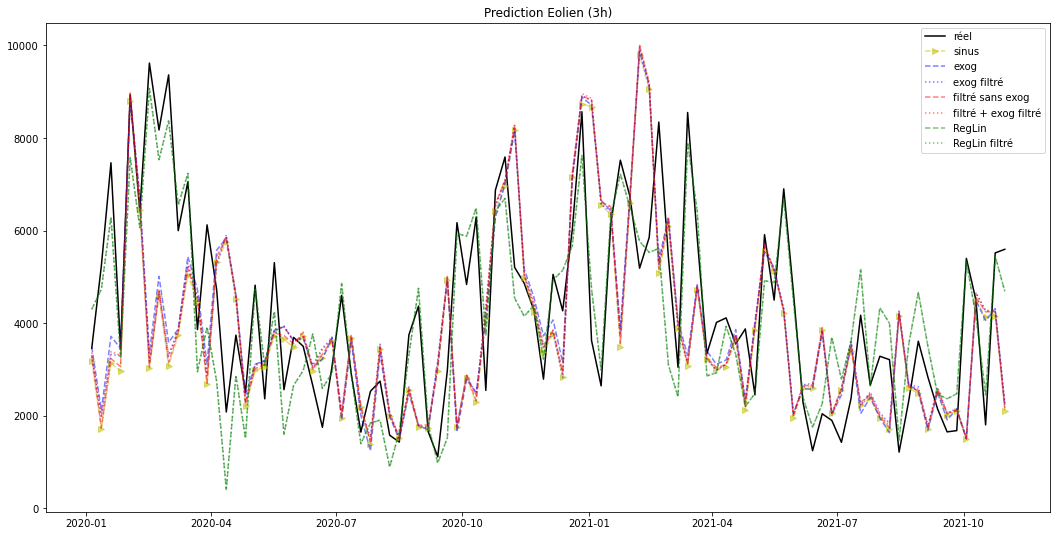

In [84]:
plt.figure(figsize=(18,9))
plt.plot(bilan['Eolien'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Eol_p_sinus'].resample('W').mean(), color = 'y', linestyle = '--', alpha = 0.5, label = 'sinus', marker = '>')
plt.plot(bilan['Eol_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
plt.plot(bilan['Eol_p_filter'].resample('W').mean(), color = 'b', linestyle = ':', alpha = 0.5, label = 'exog filtré')
plt.plot(bilan['Eol_p_reduit_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
plt.plot(bilan['Eol_p_reduit'].resample('W').mean(), color = 'r', linestyle = ':', alpha = 0.5, label = 'filtré + exog filtré')
plt.plot(bilan['Eol_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
plt.plot(bilan['Eol_p_LinReg_filter'].resample('W').mean(), color = 'g', linestyle = ':', alpha = 0.5, label = 'RegLin filtré')
plt.legend(loc = 'upper right')
plt.title('Prediction Eolien (3h)')
plt.savefig('./results/3h/pred_eolien_3h.png');

# Synthèse des erreurs

In [85]:
erreur = bilan[['Err_sinus',
       'Err_exog',
       'Err_exog_filter',
       'Err_filter_noreg',
       'Err_filter_exog_filter',
       'Err_LinReg',
       'Err_LinReg_filter'
      ]].describe()
erreur

,Err_sinus,Err_exog,Err_exog_filter,Err_filter_noreg,Err_filter_exog_filter,Err_LinReg,Err_LinReg_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,2911.169907,2826.739564,2847.921585,2930.240038,2865.486677,1530.205978,1530.136953
std,2594.516329,2495.280899,2540.222932,2587.538658,2537.796713,1161.551787,1161.529386
min,0.845849,0.063870,0.948028,0.202723,0.520115,0.583818,0.221954
25%,902.378416,937.365075,876.407062,935.000293,934.939288,617.850932,618.213847
50%,2124.098005,2096.749750,2089.029384,2152.665702,2094.581904,1281.915631,1281.444978
75%,4164.620465,4047.881504,4066.105815,4236.200944,4106.492929,2201.871620,2202.343683
max,14159.509018,14607.543473,13918.205655,14630.785328,13878.704594,6728.744457,6730.827514


In [86]:
exog_test.columns

Index(['Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'], dtype='object')

In [87]:
LinReg.coef_

array([ 9.64707422e-02,  4.62936594e-03,  2.87590008e-02, -5.24688740e-04,
       -6.80994248e-05])

In [88]:
bilan.to_csv('./results/3h/bilan_eolien_3h.csv', sep = ';')
erreur.to_csv('./results/3h/erreur_eolien_3h.csv', sep = ';')